# Models Comparison | proximity-quadrotor-learning

https://github.com/idsia-robotics/proximity-quadrotor-learning

## Settings

In [ ]:
################################
### KNOWN IMPORTS
######

import math
import os
import time
import errno
import random
import sys
import gc
from datetime import datetime

# %tensorflow_version 1.x
import tensorflow as tf

# when importing keras, please notice:
#   https://stackoverflow.com/a/57298275/10866825
#   https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# !pip install resnet
# import resnet as kr

import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# -- for GradCAM
!pip install tf-keras-vis
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm


################################
### PATHS
######

try:
  import google.colab
  IN_COLAB = True
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  drive.mount('/content/drive')
  src_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/src/'
  models_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/trained-models/'
  pickles_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/dataset/Whole Dataset/pickles/'
  new_models_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/'
  new_datasets_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-datasets/'
  visualization_folder = '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/visualization/'
  videos_folder = '/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/visualization/video/'
except:
  # this file goes into 'proximity-quadrotor-learning/marco-test' folder
  IN_COLAB = False
  from cv2 import imshow as cv2_imshow
  src_folder = 'src/'
  models_folder = '../trained-models/' # Dario's original trained models (https://drive.switch.ch/index.php/s/Idsyf8WIwQpvRMF)
  pickles_folder = '../dataset/Whole Dataset/pickles/' # Dario's original dataset (https://drive.switch.ch/index.php/s/8clDQNH645ZjWDD)
  new_models_folder = 'new-models/'
  new_datasets_folder = 'new-datasets/'
  visualization_folder = 'visualization/'
  videos_folder = 'visualization/video/'


chosen_model = 1
original_model_path = models_folder + 'v' + str(chosen_model) + '_model_train_size_50000_rep_1.h5'
pickle_train_path = pickles_folder + 'version' + str(chosen_model) + '/train.pickle'
pickle_test_path = pickles_folder + 'version' + str(chosen_model) + '/test.pickle'



################################
### CUSTOM IMPORTS
######

sys.path.append(src_folder)
import general_utils
import keras_utils

import importlib
importlib.reload(general_utils)
importlib.reload(keras_utils)

Mounted at /content/drive


<module 'marco_utils' from '/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/lib/marco_utils.py'>

## Datasets selection

In [ ]:
### Original dataset

data1_img, data1_x, data1_y, data1_actual, data1_odom = general_utils.get_dataset_from_pickle(pickle_train_path, dataset_start_index = 24000, dataset_keep_ratio = 0.25)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/dataset/Whole Dataset/pickles/version1/train.pickle
dataset original shape: (63726, 3)
dataset keep shape: 	(15931, 3)
img_data shape: 	(15931,)
x_data shape: 		(15931, 60, 108, 3)
y_data shape: 		(15931, 4)
odom_dataset shape: 	(15931, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (15931,)
y_data_for_network single classification variable (4:8) 	 (15931, 3)


In [ ]:
### Replace background dataset

nskip = 12
nbackgrounds = 20

data2_folder = new_datasets_folder + 'replace 31863 samples (start24k, skip12 = 2655) with 20 backgrounds - total 53120/20200928_164049_replacebg_df53120_1of1.pickle'
data2_img, data2_x, data2_y, data2_actual, data2_odom = general_utils.get_dataset_from_pickle(data2_folder, dataset_keep_ratio = 0.5)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-datasets/replace 31863 samples (start24k, skip12 = 2655) with 20 backgrounds - total 53120/20200928_164049_replacebg_df53120_1of1.pickle
dataset original shape: (53120, 3)
dataset keep shape: 	(26560, 3)
img_data shape: 	(26560,)
x_data shape: 		(26560, 60, 108, 3)
y_data shape: 		(26560, 4)
odom_dataset shape: 	(26560, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (26560,)
y_data_for_network single classification variable (4:8) 	 (26560, 3)


### Dataset overview

In [ ]:
### Original dataset

ncols = 10
nrows = 10
size = (nrows * ncols)

fix, ax = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*3), subplot_kw={'xticks': [], 'yticks': []})
for count, i in enumerate(range(0, nskip * size, nskip)):
  ax[count//ncols, count%ncols].imshow(data1_img[i])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
### Replace background dataset

ncols = 10
nrows = 10
size = (nrows * ncols)

# 1st image, 20 backgrounds
bg_rows = int(nbackgrounds / ncols)
fig, ax = plt.subplots(bg_rows, ncols, figsize=(ncols*5, bg_rows*3), subplot_kw={'xticks': [], 'yticks': []})
for count, i in enumerate(range(0, nbackgrounds, 1)):
  ax[count//ncols, count%ncols].imshow(data2_img[i])

# 100 images, single background
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*3), subplot_kw={'xticks': [], 'yticks': []})
for count, i in enumerate(range(0, nbackgrounds * size, nbackgrounds)):
  ax[count//ncols, count%ncols].imshow(data2_img[i])

Output hidden; open in https://colab.research.google.com to view.

## Models selection

In [ ]:
model1_name = '20200930_100322 53k_start08k_classic_simple_total53k'
model1_all, model1_vars = keras_utils.network_import_variants(new_models_folder + model1_name + '/', model1_name)

Models imported from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20200930_100322 53k_start08k_classic_simple_total53k/


In [ ]:
model2_name = '20200930_094249 31k_start24k_skip12_bg20_retrainfrom24_total53k'
model2_all, model2_vars = keras_utils.network_import_variants(new_models_folder + model2_name + '/', model2_name)

Models imported from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-models/20200930_094249 31k_start24k_skip12_bg20_retrainfrom24_total53k/


## GradCAM

In [ ]:
### Select data

vis_max_samples = 40
vis_index_start = 0

vd1_idx = range(vis_index_start, len(data1_img), nskip)
vd2_idx = range(vis_index_start*nbackgrounds, len(data2_img), 1)

vis1_img, vis1_input, vis1_actuals, vis1_predictions_best, vis1_index_start = keras_utils.gradcam_data_select_predict_transform(model1_vars, data1_img[vd1_idx], data1_x[vd1_idx], data1_actual[vd1_idx], vis_max_samples, vis_index_start)
vis2_img, vis2_input, vis2_actuals, vis2_predictions_best, vis2_index_start = keras_utils.gradcam_data_select_predict_transform(model2_vars, data2_img[vd2_idx], data2_x[vd2_idx], data2_actual[vd2_idx], vis_max_samples*nbackgrounds, vis_index_start)

gc.collect()

selected indexes are from 0 to 40 

x_class actual 		 ['medium', 'low', 'low', 'low', 'low', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', 'low', 'low', 'low', 'low', 'low', 'medium', 'medium', 'medium', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low']
x_class prediction 	 ['medium', 'low', 'low', 'low', 'low', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', 'low', 'medium', 'medium', 'medium', 'medium', 'medium', 'low', 'low', 'low', 'medium', 'low', 'low', 'low', 'low', 'low', 'low', 'medium', 'medium', 'medium', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low'] 

y_class actual 		 ['medium', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'medium', 'medium', 'high', 'high', 'high', 'high', 'medium', 'medium', 'medium', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 'low', 

1350

/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/visualization/gradcam/models-comparison/20200930_133102/20200930_133102 20200930_100322 53k_start08k_classic_simple_total53k/
Progress frame 0/1


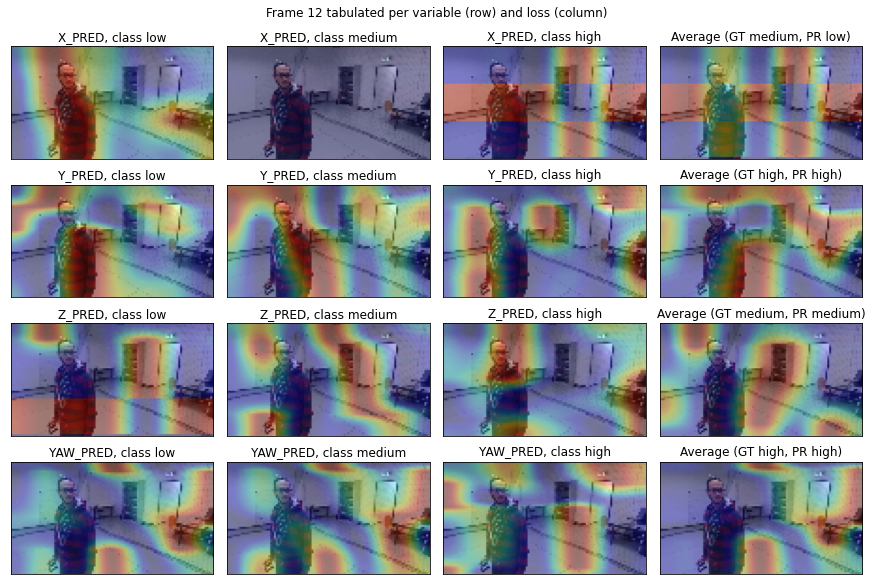

/content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/visualization/gradcam/models-comparison/20200930_133102/20200930_133110 20200930_094249 31k_start24k_skip12_bg20_retrainfrom24_total53k/
Progress frame 0/20


In [ ]:
### GradCAM

max_frames = 1
nplotted = np.min([max_frames, vis_max_samples])

timestr = time.strftime("%Y%m%d_%H%M%S")
comparison_folder = visualization_folder + 'gradcam/models-comparison/{0}/'.format(timestr)

var_types = [0, 1, 2, 3] # X:0, Y:1, Z:2, W:3
loss_types = [0, 1, 2, 3] # low:0, medium:1, high:2, total:3

# frames = np.random.choice(range(vis_input.shape[0]), nplotted, p = keras_utils.get_wave_distribution(vis_input.shape[0]))

frame_start = 12 #np.random.randint(0, len(vis1_img) - nplotted - 1)
frame_end = frame_start + nplotted # np.random.randint(0, len(vis1_img) - nplotted - 1)
frames1 = np.arange(frame_start, frame_end)
frames2 = np.arange(frame_start * nbackgrounds, frame_end * nbackgrounds)

keras_utils.gradcam_comparison_varloss(
    vis1_img, vis1_input, vis1_actuals, vis1_predictions_best, vis1_index_start,
    var_types, loss_types, model1_vars, frames1, 
    comparison_folder, notes = model1_name, title = True, save = True
)

keras_utils.gradcam_comparison_varloss(
    vis2_img, vis2_input, vis2_actuals, vis2_predictions_best, vis2_index_start,
    var_types, loss_types, model2_vars, frames2, 
    comparison_folder, notes = model2_name, title = True, save = True
)

## Performance on the test set

In [ ]:
test1_img, test1_x, test1_y, test1_actual, test1_odom = general_utils.get_dataset_from_pickle(pickle_test_path, dataset_keep_ratio = 1)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/dataset/Whole Dataset/pickles/version1/test.pickle
dataset original shape: (11035, 3)
dataset keep shape: 	(11035, 3)
img_data shape: 	(11035,)
x_data shape: 		(11035, 60, 108, 3)
y_data shape: 		(11035, 4)
odom_dataset shape: 	(11035, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (11035,)
y_data_for_network single classification variable (4:8) 	 (11035, 3)


In [ ]:
test2_folder = new_datasets_folder + 'replace 11035 samples (start0, skip10 = 1103) with 20 backgrounds - total 22080 TEST/20201001_160539_replacebg_df22080_1of1.pickle'
test2_img, test2_x, test2_y, test2_actual, test2_odom = general_utils.get_dataset_from_pickle(test2_folder, 0, dataset_keep_ratio = 1)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/proximity-quadrotor-learning/marco-test/new-datasets/replace 11035 samples (start0, skip10 = 1103) with 20 backgrounds - total 22080 TEST/20201001_160539_replacebg_df22080_1of1.pickle
dataset original shape: (22080, 3)
dataset keep shape: 	(22080, 3)
img_data shape: 	(22080,)
x_data shape: 		(22080, 60, 108, 3)
y_data shape: 		(22080, 4)
odom_dataset shape: 	(22080, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (22080,)
y_data_for_network single classification variable (4:8) 	 (22080, 3)


In [ ]:
test1_metrics = model1_all.evaluate(test1_x, test1_y[4:8], batch_size=64, return_dict=True)
print('Arena model on the original test set')
print(test1_metrics)

173/173 [==============================] - 47s 273ms/step - loss: 2.5170 - x_class_loss: 0.6581 - y_class_loss: 0.4461 - z_class_loss: 0.4520 - w_class_loss: 0.9609 - x_class_accuracy: 0.7125 - y_class_accuracy: 0.8333 - z_class_accuracy: 0.8214 - w_class_accuracy: 0.7226

{'loss': 2.5170300006866455, 'x_class_loss': 0.6581394076347351, 'y_class_loss': 0.44605693221092224, 'z_class_loss': 0.45196202397346497, 'w_class_loss': 0.9608709216117859, 'x_class_accuracy': 0.7124603390693665, 'y_class_accuracy': 0.833257794380188, 'z_class_accuracy': 0.8213865160942078, 'w_class_accuracy': 0.7226098775863647}


In [ ]:
test2_metrics_arena = model2_all.evaluate(test1_x, test1_y[4:8], batch_size=64, return_dict=True)
print('20backgrounds model on the original test set')
print(test2_metrics_arena)

173/173 [==============================] - 46s 267ms/step - loss: 3.3069 - x_class_loss: 0.9079 - y_class_loss: 0.6955 - z_class_loss: 0.7017 - w_class_loss: 1.0017 - x_class_accuracy: 0.7219 - y_class_accuracy: 0.8221 - z_class_accuracy: 0.8328 - w_class_accuracy: 0.7108

{'loss': 3.306882619857788, 'x_class_loss': 0.9079230427742004, 'y_class_loss': 0.6955298185348511, 'z_class_loss': 0.701730489730835, 'w_class_loss': 1.001699447631836, 'x_class_accuracy': 0.7218849062919617, 'y_class_accuracy': 0.8221114873886108, 'z_class_accuracy': 0.8328047394752502, 'w_class_accuracy': 0.7108291983604431}


In [ ]:
test2_metrics_new = model2_all.evaluate(test2_x, test2_y[4:8], batch_size=64, return_dict=True)
print('20backgrounds model on the 20backgrounds test set')
print(test2_metrics_new)

345/345 [==============================] - 92s 266ms/step - loss: 3.7128 - x_class_loss: 1.0263 - y_class_loss: 0.7715 - z_class_loss: 0.8604 - w_class_loss: 1.0546 - x_class_accuracy: 0.6046 - y_class_accuracy: 0.7208 - z_class_accuracy: 0.7235 - w_class_accuracy: 0.6042

{'loss': 3.7127764225006104, 'x_class_loss': 1.0262905359268188, 'y_class_loss': 0.7714831233024597, 'z_class_loss': 0.8604363799095154, 'w_class_loss': 1.0545638799667358, 'x_class_accuracy': 0.6045742630958557, 'y_class_accuracy': 0.7207880616188049, 'z_class_accuracy': 0.723505437374115, 'w_class_accuracy': 0.6042119860649109}
